In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import ruptures as rpt

In [3]:
df_autoconsumo = pd.read_parquet('./data/tramita/exp_autoconsumo.parquet')

# Create time series

In [4]:
df_autoconsumo.set_index('fecha_registro_exp', inplace=True)

In [5]:
ts_autoconsumo = df_autoconsumo.resample('D').agg(
    total_exp=('id_exp', 'count')
).fillna(0).reset_index()
ts_autoconsumo.set_index('fecha_registro_exp', inplace=True)

In [6]:
ts_autoconsumo.head()

,total_exp
fecha_registro_exp,
2021-12-22,317
2021-12-23,282
2021-12-24,124
2021-12-25,22
2021-12-26,52


# Change point detection

In [11]:
# Extract data for analysis
signal = ts_autoconsumo["total_exp"].values  # Get the data as a numpy array

# Binary Segmentation model with "l2" cost (least squares)
model = rpt.Binseg(model="l2")

# Number of change points to detect
n_bkps = 5

# Fit the model and predict change points
model.fit(signal)
change_points = model.predict(n_bkps=n_bkps)


(<Figure size 2000x500 with 1 Axes>, [<Axes: >])

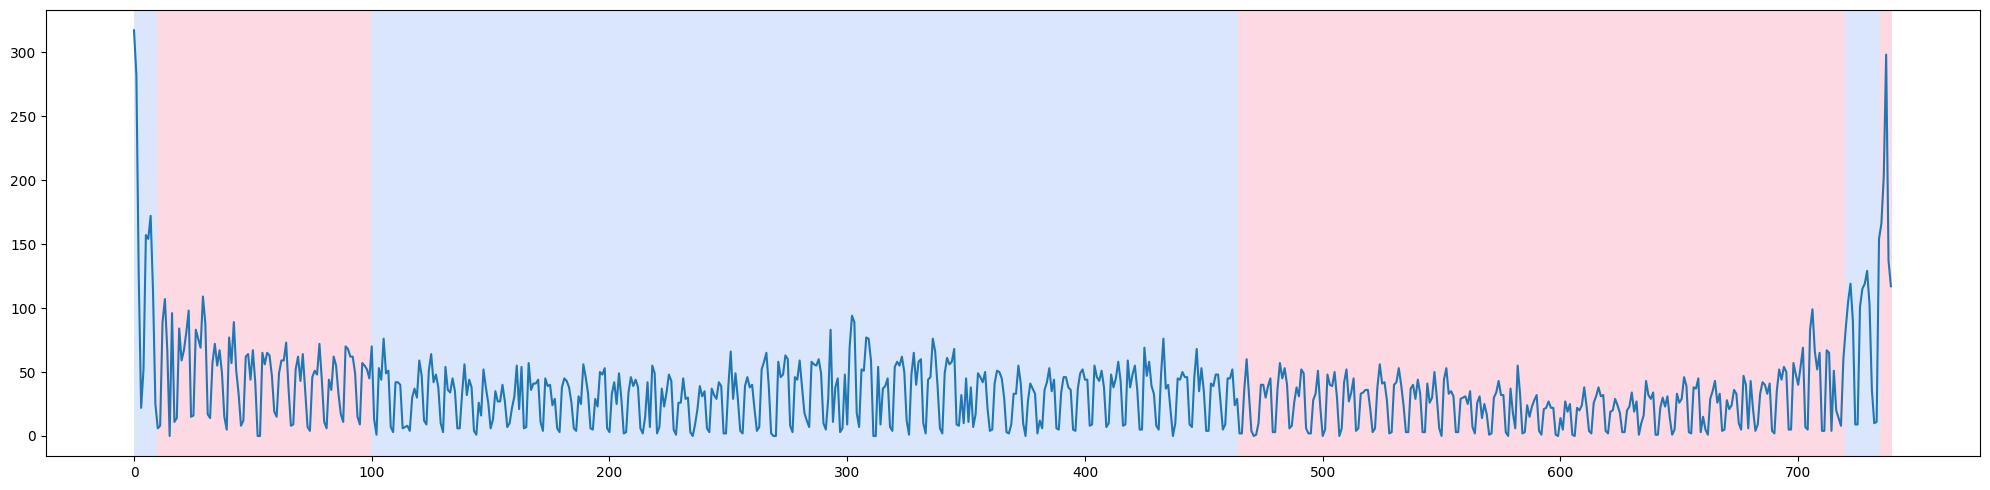

In [12]:
# Display results
rpt.display(signal, change_points, figsize=(20, 5))

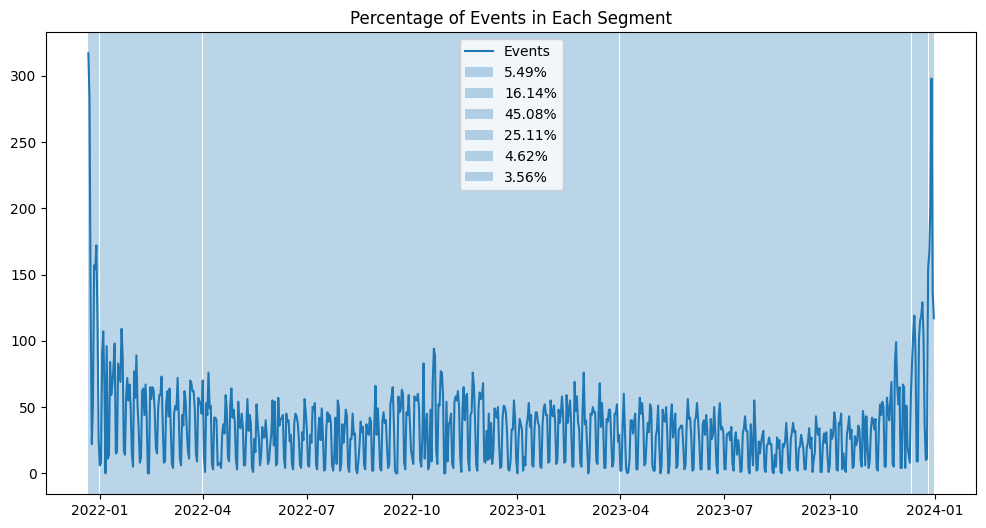

In [13]:

total_events = ts_autoconsumo["total_exp"].sum()
segments = []

#Compute percentage of events in each segment
prev_idx = 0
for idx in change_points:
    segment_sum = ts_autoconsumo["total_exp"].iloc[prev_idx:idx].sum()
    percentage = (segment_sum / total_events) * 100
    segments.append((prev_idx, idx, percentage))
    prev_idx = idx

#Plot segments with percentages using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(ts_autoconsumo.index, ts_autoconsumo["total_exp"], label="Events")

for start, end, pct in segments:
    plt.axvspan(ts_autoconsumo.index[start], ts_autoconsumo.index[end - 1], 
                alpha=0.3, label=f"{pct:.2f}%")

plt.legend()
plt.title("Percentage of Events in Each Segment")
plt.show()

    

# White noise

In [11]:
ts_autoconsumo.describe()

,total_exp
count,740.000000
mean,34.925676
std,31.971590
min,0.000000
25%,9.000000
50%,33.000000
75%,48.000000
max,317.000000


In [16]:
wn = np.random.normal(loc = ts_autoconsumo.total_exp.mean(), scale = ts_autoconsumo.total_exp.std(), size = len(ts_autoconsumo))

In [17]:
ts_autoconsumo['wn'] = wn

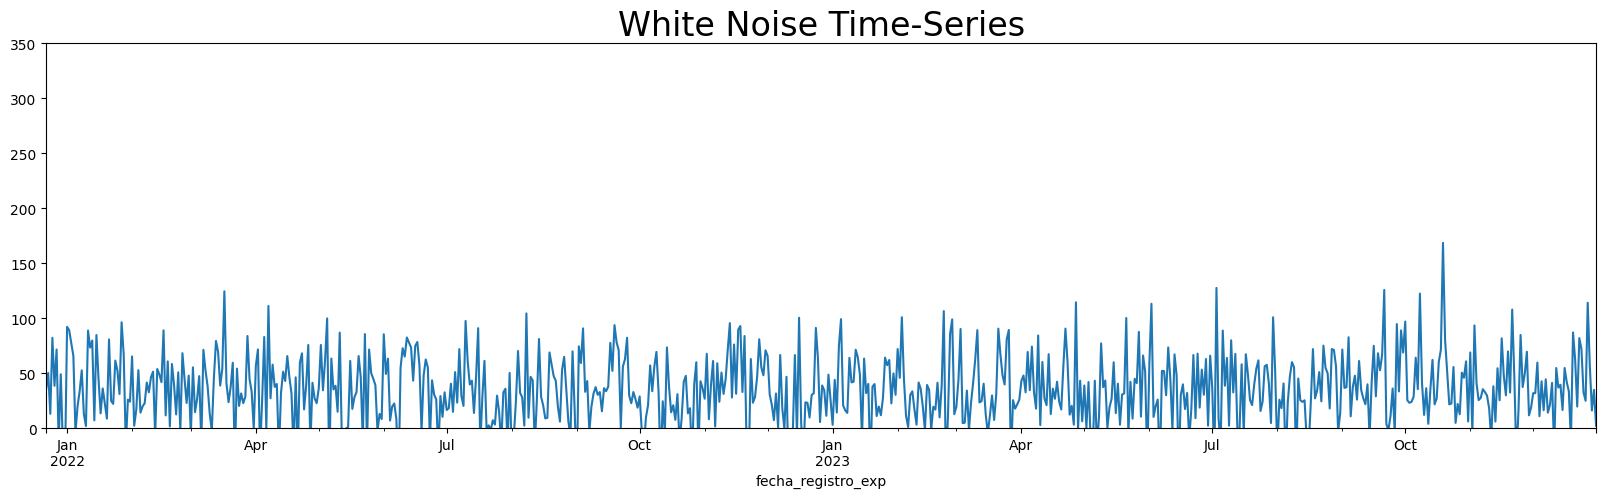

In [21]:
ts_autoconsumo.wn.plot(figsize = (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.ylim(0,350)
plt.show()

In [19]:
ts_autoconsumo.describe()

,total_exp,wn
count,740.000000,740.000000
mean,34.925676,35.924801
std,31.971590,31.627723
min,0.000000,-51.420750
25%,9.000000,15.091318
50%,33.000000,34.448731
75%,48.000000,57.056720
max,317.000000,168.647412


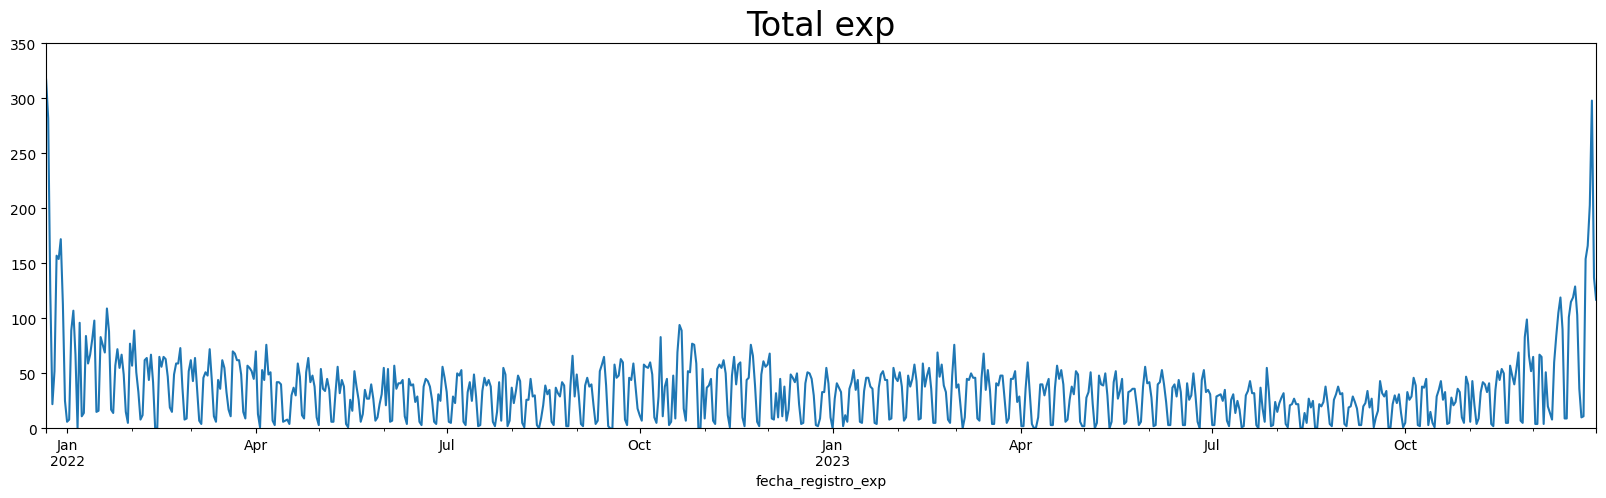

In [20]:
ts_autoconsumo.total_exp.plot(figsize=(20,5))
plt.title("Total exp", size = 24)
plt.ylim(0,350)
plt.show()

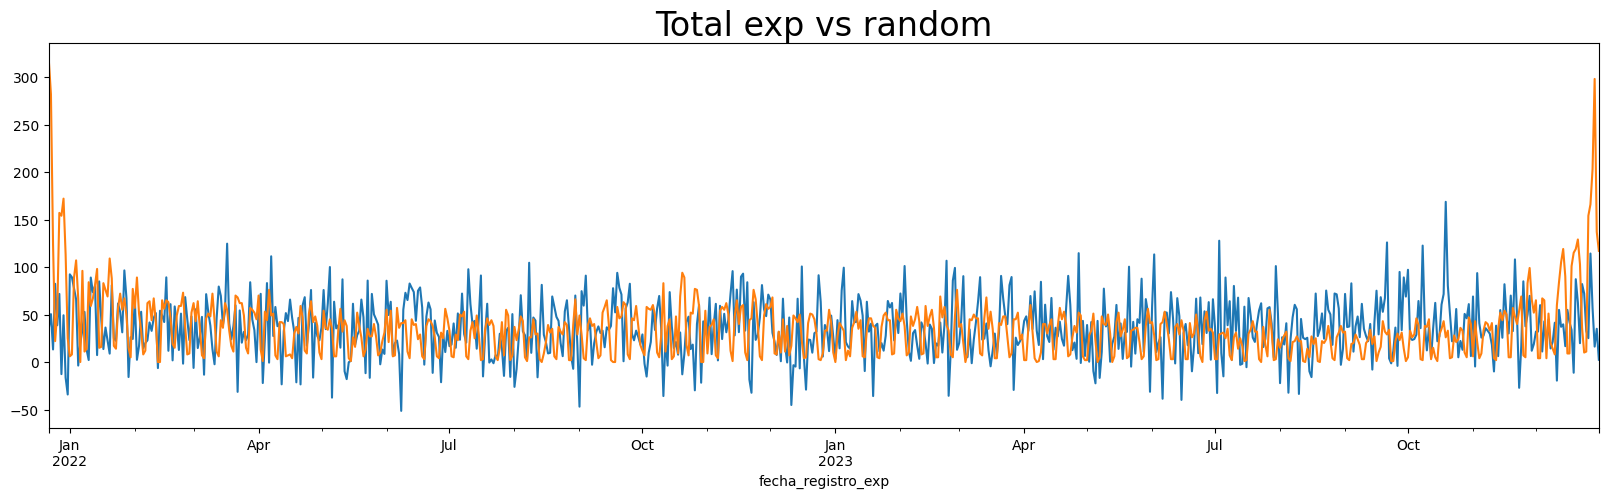

In [24]:
ts_autoconsumo.wn.plot(figsize = (20,5))
ts_autoconsumo.total_exp.plot()
plt.title("Total exp vs random", size = 24)
plt.show()

# Stationarity

It's particularly good at detecting trending behavior

**ADF Statistic (result[0]):**
This is the test statistic calculated from your data. More negative = stronger evidence for stationarity.Compare this with the critical values

**p-value (result[1]):**
Null hypothesis: Series is non-stationary (has a unit root) 

If p-value < significance level (typically 0.05): Reject null hypothesis Conclude series is stationary

If p-value > 0.05: Fail to reject null hypothesis Series might be non-stationary

**Critical Values (result[4]):**
Usually reported at 1%, 5%, and 10% significance levels If ADF statistic is more negative than critical value: Reject null hypothesis at that ignificance level

In [28]:
sts.adfuller(ts_autoconsumo.total_exp)

(0.4615858346725935,
 0.9836575578793152,
 13,
 726,
 {'1%': -3.4393893552577723,
  '5%': -2.8655292671104644,
  '10%': -2.5688943376666744},
 6016.865613739552)

non stationary, 98% de probabilidad

# Seasonality

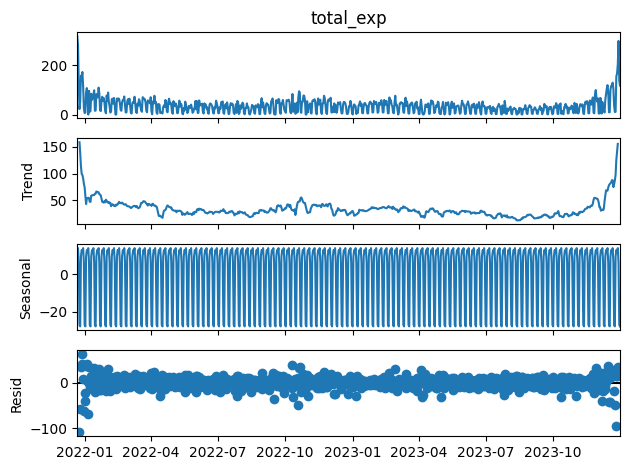

In [30]:
s_dec_additive = seasonal_decompose(ts_autoconsumo.total_exp, model = "additive")
s_dec_additive.plot()
plt.show()

In [39]:
# s_dec_multiplicative = seasonal_decompose(ts_autoconsumo.total_exp, model = "multiplicative")
# s_dec_multiplicative.plot()
# plt.show()

In [34]:
ts_autoconsumo[ts_autoconsumo.total_exp == 0].count()

total_exp    17
wn           17
dtype: int64

# PACF

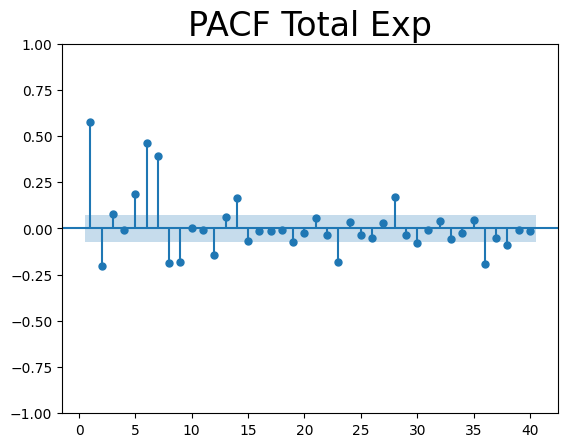

In [41]:
sgt.plot_pacf(ts_autoconsumo.total_exp, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Total Exp", size = 24)
plt.show()